In [ ]:
# Install ultralytics
!pip install ultralytics

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob

In [4]:
# Check the runtime type
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.1.0+cu121 (Tesla T4)


In [5]:
images_path = '/content/drive/MyDrive/Dataset/Fashion/JPEGImages/'
annotations_path  = '/content/drive/MyDrive/Dataset/Fashion/Annotations_txt/'
path = '/content/drive/MyDrive/Dataset/Fashion/'

In [6]:
from ultralytics import YOLO

# loading the model
detection_model = YOLO("/content/yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 396MB/s]


100%|██████████| 151k/151k [00:00<00:00, 415kB/s]


image 1/1 /content/GRdCC.jpg: 448x640 1 person, 1 bicycle, 5 cars, 1 truck, 96.2ms
Speed: 14.0ms preprocess, 96.2ms inference, 630.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


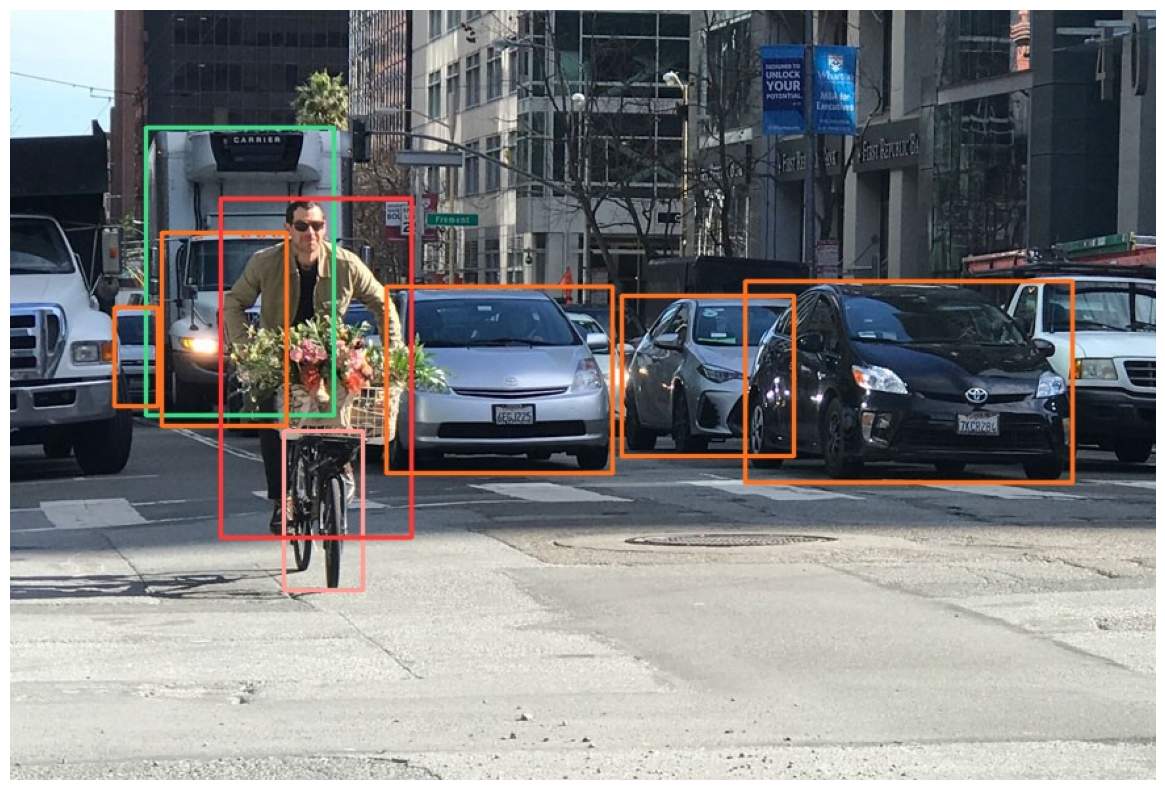

In [7]:
# choose random image
img = random.choice(os.listdir(images_path))

i=detection_model.predict(source='https://i.stack.imgur.com/GRdCC.jpg', conf=0.5, save=True, line_width=2, show_labels=False)

im = plt.imread('/content/runs/detect/predict/GRdCC.jpg')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)

In [8]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])

            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

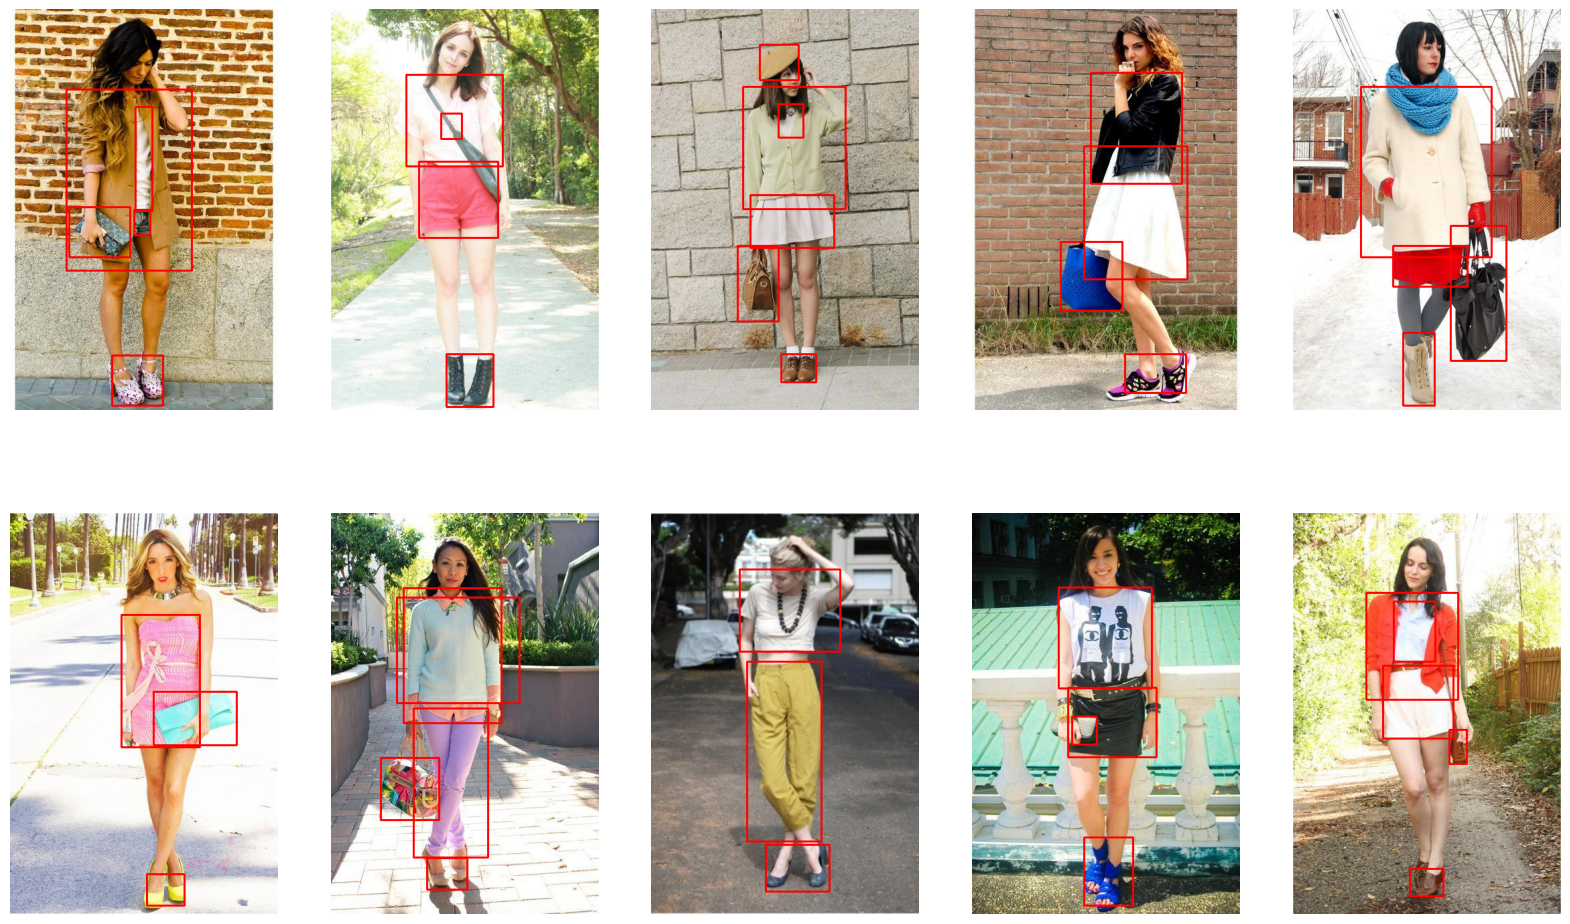

In [9]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(20,12))
ls = os.listdir('/content/drive/MyDrive/Dataset/Fashion/JPEGImages')
c = 1

for i in random.sample(ls, 10):
    img = plt.imread ('/content/drive/MyDrive/Dataset/Fashion/JPEGImages/'+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(2,5, c)
    plot_annotations(img, i)
    c+=1

In [10]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [11]:
len(train), len(test)

(2145, 537)

In [12]:
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working')
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/train')
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/train/images')
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/train/labels')

os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/test')
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/test/images')
os.mkdir('/content/drive/MyDrive/Dataset/Fashion/working/test/labels')

In [13]:
train_path = '/content/drive/MyDrive/Dataset/Fashion/working/train/'
test_path = '/content/drive/MyDrive/Dataset/Fashion/working/test/'

print('Copying Train Data..!!')
print(images_path)
print(train_path)

for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!
/content/drive/MyDrive/Dataset/Fashion/JPEGImages/
/content/drive/MyDrive/Dataset/Fashion/working/train/


100%|██████████| 2145/2145 [32:00<00:00,  1.12it/s]


Copying Test Data..!!


100%|██████████| 537/537 [07:35<00:00,  1.18it/s]


In [14]:
text = """
train: /content/drive/MyDrive/Dataset/Fashion/working/train/
val: /content/drive/MyDrive/Dataset/Fashion/working/test/

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("/content/data.yaml", 'w') as file:
    file.write(text)

In [15]:
model = YOLO("/content/yolov8m.pt")

model.train(data='/content/data.yaml', epochs=5)

Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8m.pt, data=/content/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 141MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 223MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Dataset/Fashion/working/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:35<00:00, 60.80it/s] 


train: New cache created: /content/drive/MyDrive/Dataset/Fashion/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Dataset/Fashion/working/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:06<00:00, 77.59it/s] 


val: New cache created: /content/drive/MyDrive/Dataset/Fashion/working/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.01G        1.3      1.834       1.43         14        640: 100%|██████████| 135/135 [01:20<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.96it/s]

                   all        537       2035       0.62      0.669       0.67      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.25G      1.238      1.224       1.37          8        640: 100%|██████████| 135/135 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all        537       2035      0.698      0.666      0.703      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.24G      1.214      1.139       1.36          7        640: 100%|██████████| 135/135 [01:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        537       2035      0.678      0.707      0.726      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.21G      1.177      1.032      1.337          7        640: 100%|██████████| 135/135 [01:12<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]

                   all        537       2035      0.758      0.725      0.762      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.26G      1.154     0.9843      1.329         11        640: 100%|██████████| 135/135 [01:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.27it/s]

                   all        537       2035      0.738      0.741      0.761      0.506



5 epochs completed in 0.119 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.17 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25845550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]


                   all        537       2035      0.739      0.741      0.761      0.506
              sunglass        537         82      0.727      0.195      0.327       0.12
                   hat        537         77       0.74      0.714       0.74      0.451
                jacket        537        181      0.762       0.78      0.831      0.627
                 shirt        537        366      0.774      0.814       0.82      0.574
                 pants        537        114      0.725      0.947      0.956      0.735
                shorts        537        107      0.791      0.841      0.826      0.509
                 skirt        537        186      0.714      0.806      0.812      0.619
                 dress        537        128      0.626      0.828      0.739      0.558
                   bag        537        274      0.763      0.693      0.757      0.419
                  shoe        537        520      0.765      0.789      0.802      0.448
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b9cdc052a40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

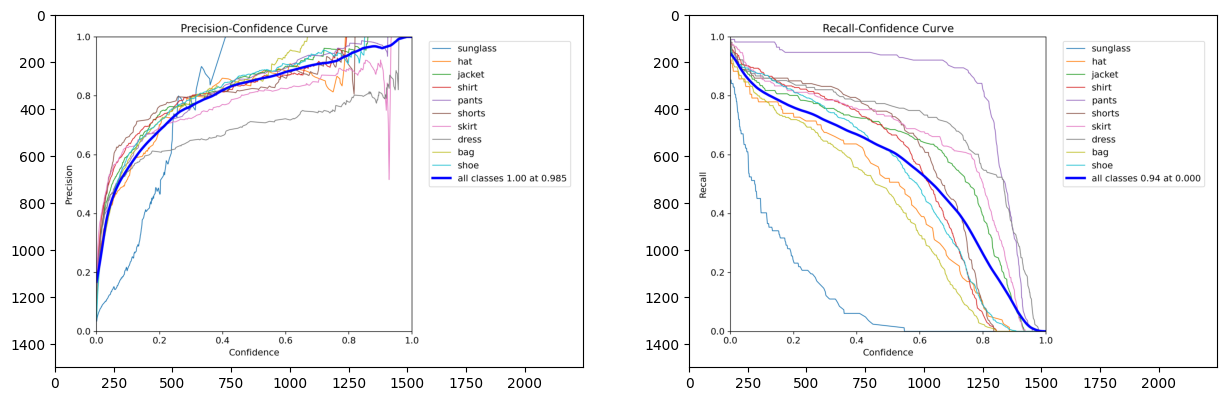

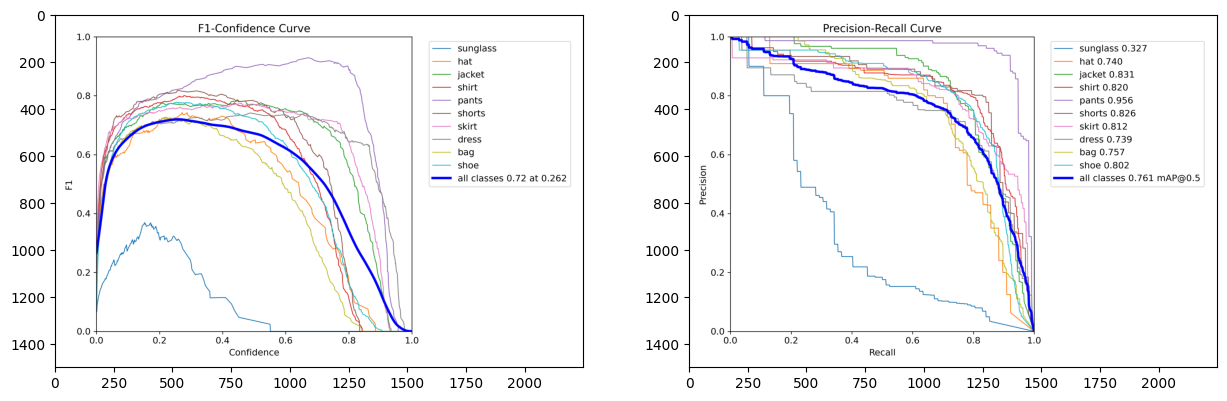

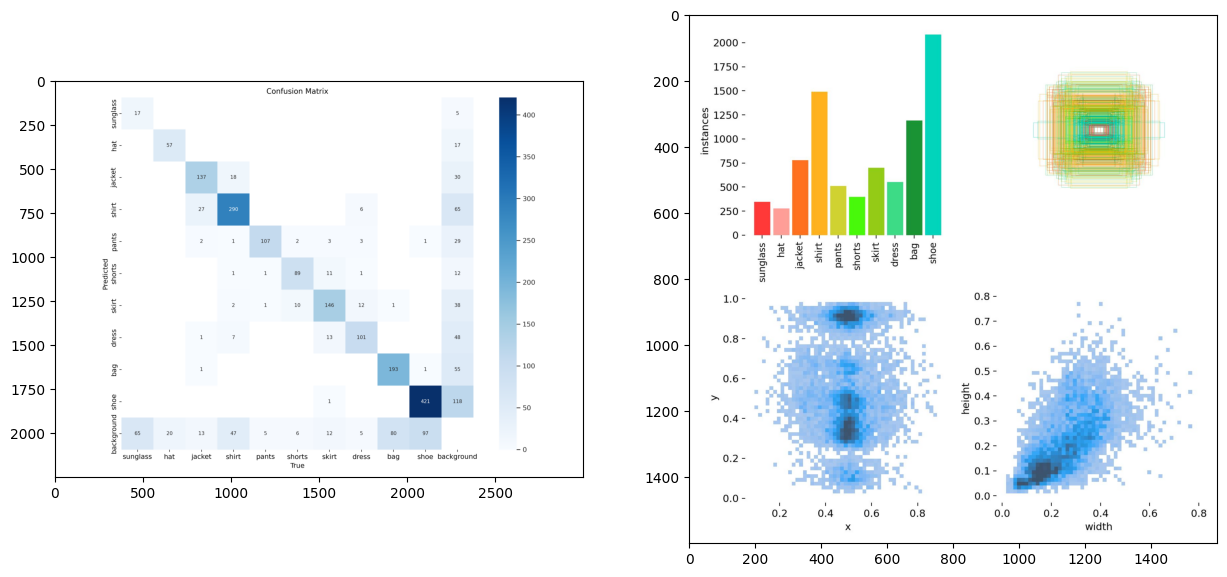

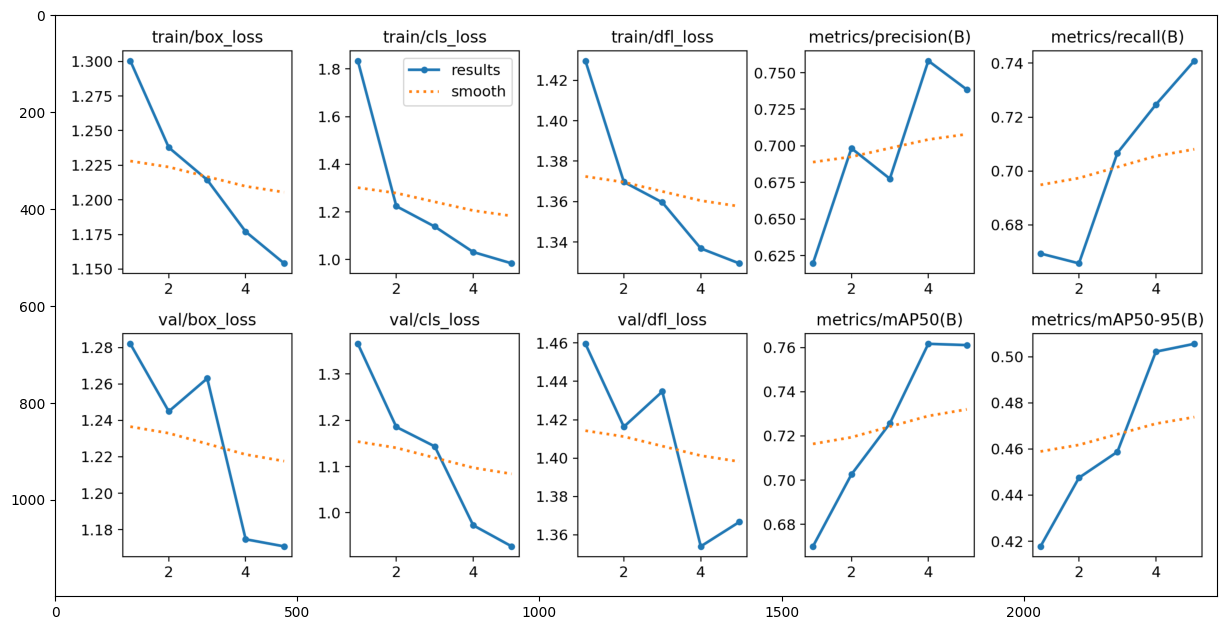

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline
model_path = '/content/runs/detect/train/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

/content

image 1/1 /content/drive/MyDrive/Dataset/Fashion/JPEGImages/186981.jpg: 640x448 1 shirt, 1 pants, 1 bag, 1 shoe, 117.3ms
Speed: 2.8ms preprocess, 117.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Dataset/Fashion/JPEGImages/190949.jpg: 640x448 1 shirt, 1 shorts, 1 bag, 1 shoe, 27.0ms
Speed: 2.1ms preprocess, 27.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Dataset/Fashion/JPEGImages/44600.jpg: 640x448 1 hat, 1 shirt, 1 shorts, 2 shoes, 26.7ms
Speed: 1.9ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)
Results saved to /content/runs/detect/predict2

image 1/1 /content/drive/MyDrive/Dataset/Fashion/JPEGImages/158894.jpg: 640x448 2 dresss, 1 shoe, 26.7ms
Speed: 2.0ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3,

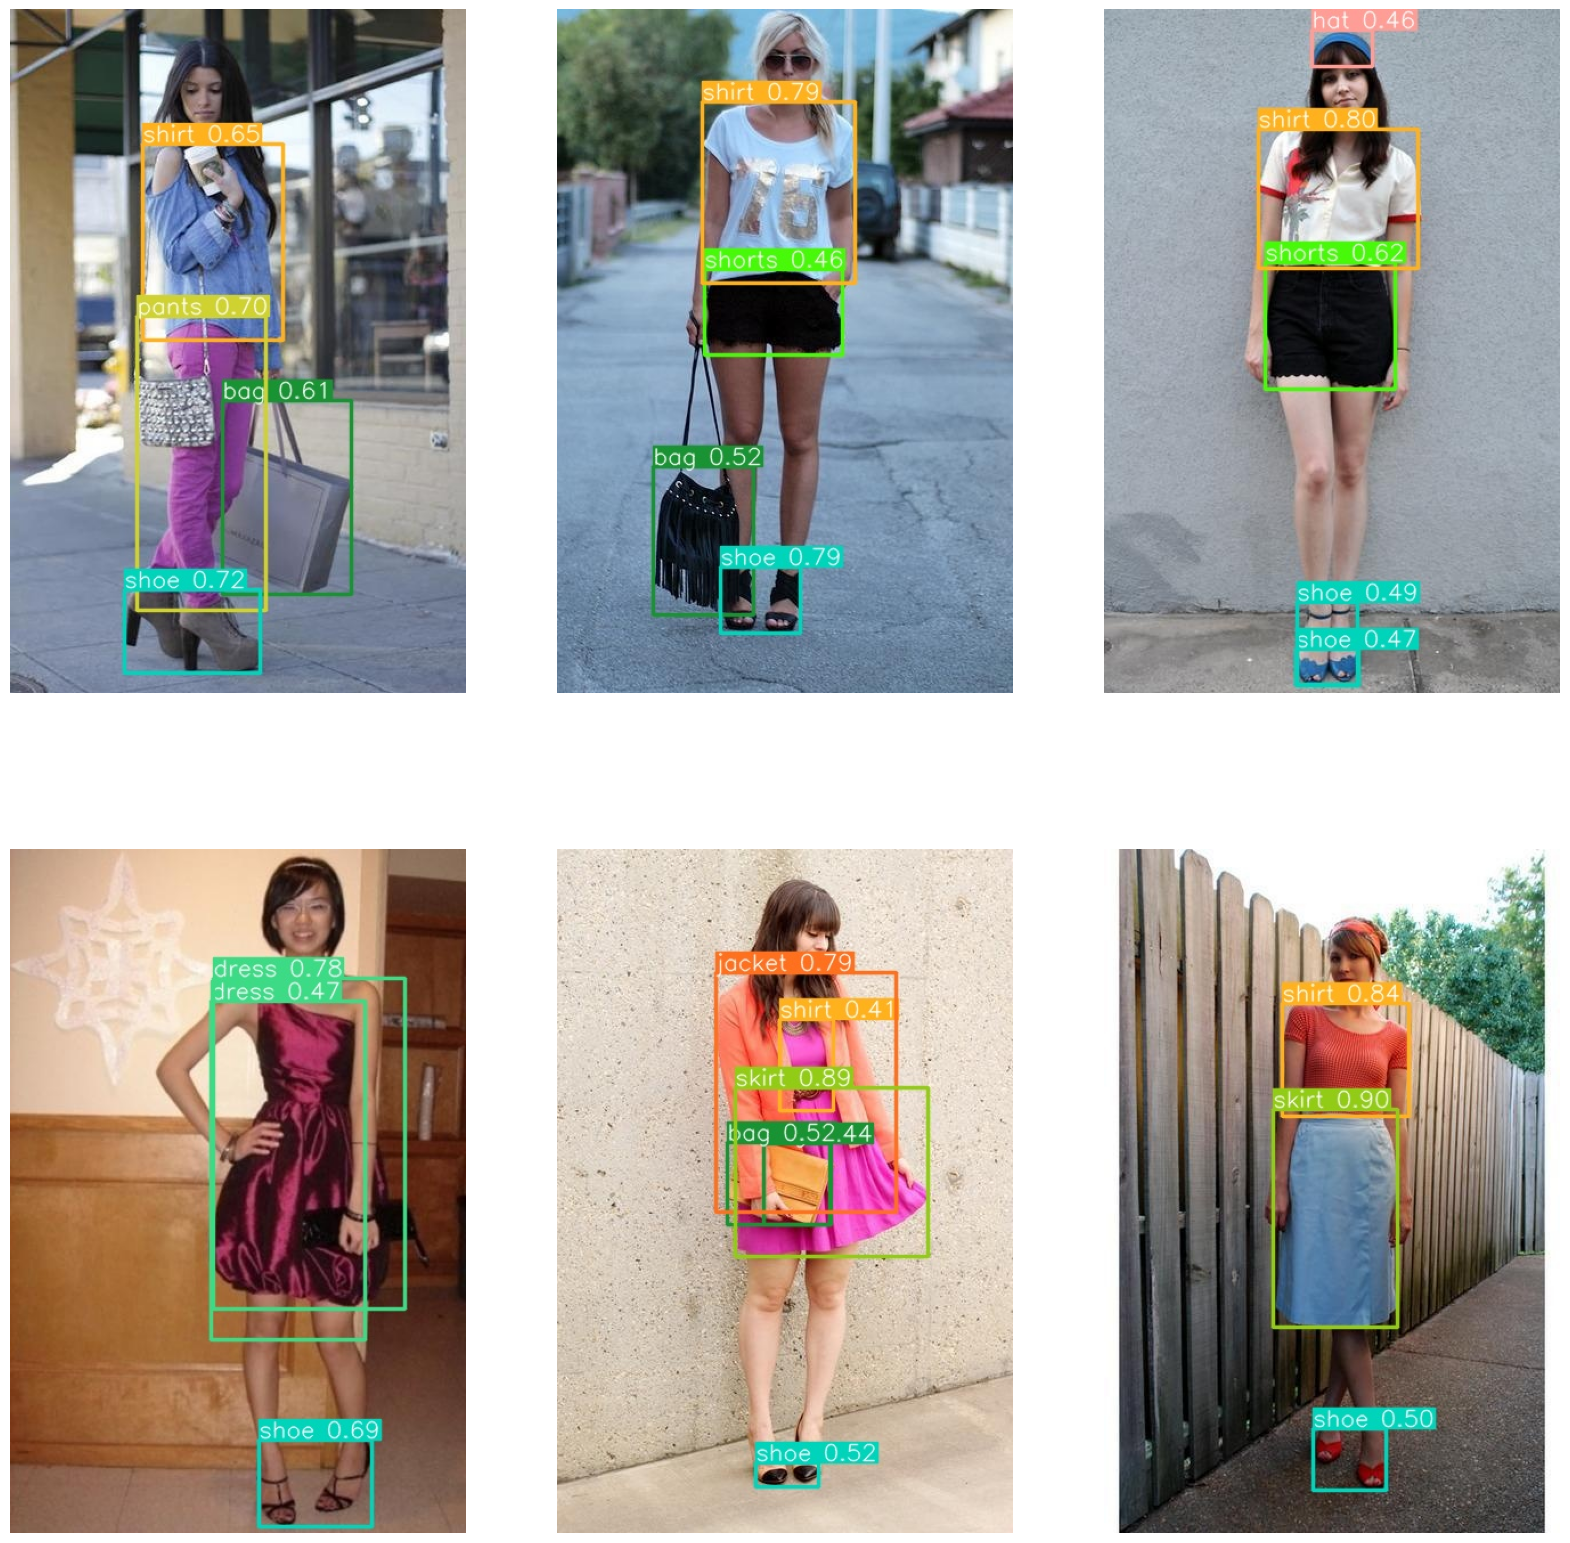

In [17]:
# choose random image from dataset

plt.figure(figsize=(20,20))
imgs = random.sample(os.listdir(images_path), 6)
c=1
print(os.getcwd())
for img in imgs:
    i=model.predict(source=images_path+img, exist_ok = True, conf=0.4, save=True, line_width=2, project="/content/runs/detect/", name = 'predict2')
    im = plt.imread('/content/runs/detect/predict2/'+img)
    plt.subplot(2,3,c)
    plt.axis('off')
    plt.imshow(im)
    c+=1

Saving sara.jpg to sara.jpg


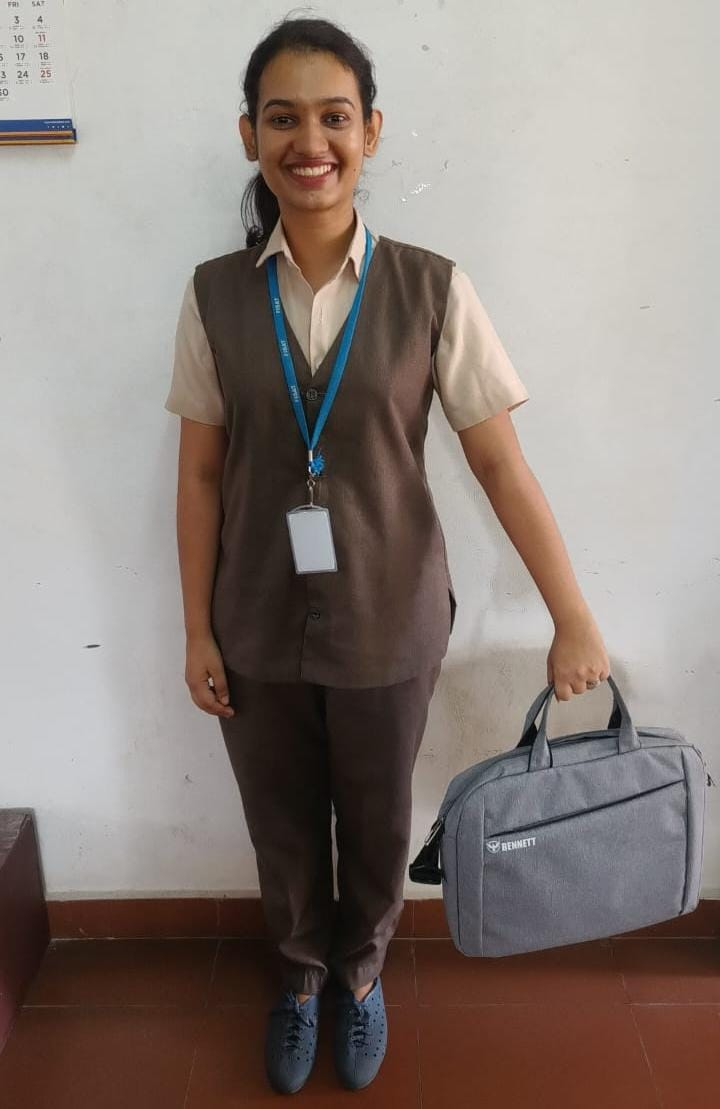

In [18]:
from google.colab import files
from IPython.display import Image

# Upload an image file
uploaded = files.upload()

# Get the filename of the uploaded image
uploaded_file = list(uploaded.keys())[0]

# Display the uploaded image with a specific width and height
Image(filename=uploaded_file,height=400)


/content

image 1/1 /content/sara.jpg: 640x416 1 jacket, 1 dress, 1 bag, 1 shoe, 108.5ms
Speed: 3.3ms preprocess, 108.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)
Results saved to /content/runs/detect/predict2


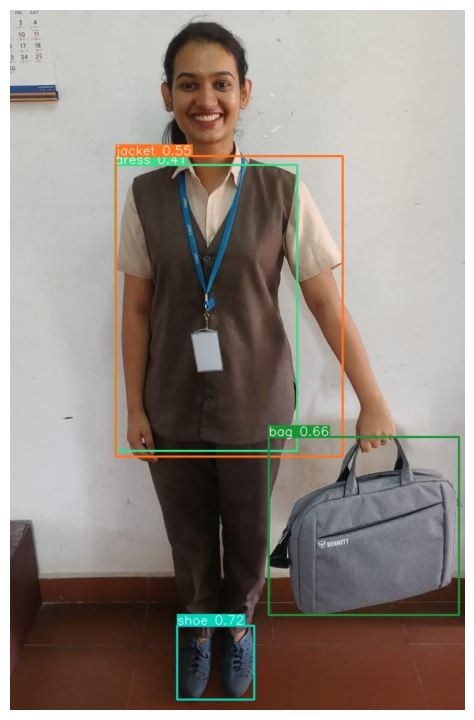

In [19]:
plt.figure(figsize=(20,20))
c=1
print(os.getcwd())
i=model.predict(source=uploaded_file, exist_ok = True, conf=0.4, save=True, line_width=2, project="/content/runs/detect/", name = 'predict2')
im = plt.imread('/content/runs/detect/predict2/'+uploaded_file)
plt.subplot(2,3,c)
plt.axis('off')
plt.imshow(im)
c+=1